# Residual fitting

This notebook trains a neural network to fit residuals left after a component model is trained. The ensemble model here takes a prediction distribution from a single component model and tries to fit the error using the actual data and the peak of the distribution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import data
import utils
import losses
import pymmwr

from functools import partial, reduce

from keras.layers import (Activation, Dense, Dropout, Embedding, Flatten, Merge, Reshape)
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import keras.backend as K
from sklearn.model_selection import train_test_split
from scipy.stats import norm

Using Theano backend.


## Load data

In [3]:
class Component:
    """
    Helper class for working with components
    """
    
    def __init__(self, name):
        self.name = name
        self.loader = data.ComponentDataLoader("../data", name)

In [4]:
component = Component("ReichLab-SARIMA1")
actual_dl = data.ActualDataLoader("../data")

## Working on week ahead predictions

In [83]:
REGION = None # Specify None for using all the data
WEEK_NUMBER = 2

y, Xs, yi = data.get_week_ahead_training_data(
    WEEK_NUMBER, REGION,
    actual_dl, [component.loader]
)

component.data = Xs[0]

### Getting error using the distribution max

In [84]:
component_out = utils.get_merged_features(
    Xs, 
    [utils.dist_max]
)[:, 0]

component_error = y - component_out

## Network inputs and outputs

The network will take distribution peak from the component, a week encoding and fit on *model_error*

In [85]:
def encode_epiweek(epiweek: int):
    """
    Encode epiweek of the form YYYYWW
    """
    
    year = epiweek // 100
    week = epiweek % 100
    
    # Get the limit of weeks in year
    n_weeks = pymmwr.mmwr_weeks_in_year(year)
    
    radian = 2 * np.pi * week / n_weeks
    
    return np.array([np.sin(radian), np.cos(radian)])

weeks = np.array([encode_epiweek(ew) for ew in yi[:, 0]])

Training on data before 201443

In [86]:
train_indices = yi[:, 0] < 201443

## Model

In [87]:
def res_mod(n_input):
    """
    Return an error fit model
    """
    
    model = Sequential()
    model.add(Dense(5, input_shape=(n_input,)))
    model.add(Activation("relu"))
#     model.add(Dense(5))
#     model.add(Activation("relu"))
    model.add(Dense(5))
    model.add(Activation("relu"))
    
    # Return the error
    model.add(Dense(1))
    
    return model

In [88]:
model = res_mod(3)

In [89]:
model.compile(optimizer="rmsprop", loss="mae")

early_stop = EarlyStopping(monitor="val_loss", patience=4, mode="auto")

model_in = np.concatenate([component_out[train_indices][:, None], weeks[train_indices]], axis=1)

history = model.fit(model_in,
                    component_error[train_indices],
                    batch_size=64, epochs=100,
                    verbose=1,
                    callbacks=[early_stop],
                    validation_split=0.1)

Train on 1336 samples, validate on 149 samples
Epoch 1/100
1336/1336 [==============================] - 0s - loss: 0.5527 - val_loss: 0.4004
Epoch 2/100
1336/1336 [==============================] - 0s - loss: 0.4952 - val_loss: 0.4033
Epoch 3/100
1336/1336 [==============================] - 0s - loss: 0.4710 - val_loss: 0.4004
Epoch 4/100
1336/1336 [==============================] - 0s - loss: 0.4587 - val_loss: 0.3972
Epoch 5/100
1336/1336 [==============================] - 0s - loss: 0.4517 - val_loss: 0.3915
Epoch 6/100
1336/1336 [==============================] - 0s - loss: 0.4478 - val_loss: 0.3950
Epoch 7/100
1336/1336 [==============================] - 0s - loss: 0.4458 - val_loss: 0.3908
Epoch 8/100
1336/1336 [==============================] - 0s - loss: 0.4439 - val_loss: 0.3925
Epoch 9/100
1336/1336 [==============================] - 0s - loss: 0.4425 - val_loss: 0.3860
Epoch 10/100
1336/1336 [==============================] - 0s - loss: 0.4412 - val_loss: 0.3844
Epoch 11/100

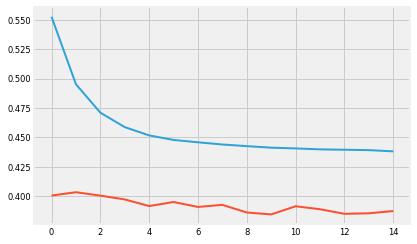

In [90]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

## Evaluation

In [91]:
regions = ["nat", *[f"hhs{i}" for i in range(1, 11)], None]

models = [component.name, "Res-fit"]

eval_df = {model: [] for model in models}

for region in regions:
    if region is None:
        eval_indices = ~train_indices
    else:
        eval_indices = (~train_indices) & (yi[:, 1] == region)
        
    component_dist = component.data[eval_indices]
    model_in = np.concatenate([component_out[eval_indices][:, None], weeks[eval_indices]], axis=1) 
    rf_dist = utils.shift_distribution(component_dist, model.predict(model_in)[:, 0])

    dists = [
        component_dist,
        rf_dist
    ]
    y_one_hot = utils.wili_to_dists(y[eval_indices])
    
    for name, output in zip(models, dists):
        eval_df[name].append(K.categorical_crossentropy(output, y_one_hot).mean().eval())
        
eval_df = pd.DataFrame(eval_df)
eval_df.index = [*regions[:-1], "All"]

In [92]:
eval_df

,ReichLab-SARIMA1,Res-fit
nat,2.6984609575393907,3.469046594204509
hhs1,2.8695329976928363,2.7214269041819215
hhs2,3.5268609460874263,3.586483322007389
hhs3,3.204720078270798,3.266466328342782
hhs4,3.0104005931704876,3.365255127379452
hhs5,2.8255767200749378,3.08445406122986
hhs6,3.9220034690959893,3.7740313606752847
hhs7,3.1813257639351895,3.595241355491771
hhs8,2.901717501595002,2.8242592577912196
hhs9,3.302682642716768,3.065953923210447
